In [1]:
import random
import itertools
import numpy as np
from tqdm import tqdm

class Agent:
    def __init__(self, agent_id, possible_actions, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.agent_id = agent_id
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = {}
        self.possible_actions = possible_actions
        self.previous_state = None
        self.previous_action = None

    def choose_action(self, current_joint_state, env):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.possible_actions)
        else:
            action_combinations = list(itertools.product(self.possible_actions, repeat=len(current_joint_state)))
            max_q = -float('inf')
            best_combos = []
            for combo in action_combinations:
                next_joint_state = []
                for idx, action in enumerate(combo):
                    pos, rewards_active = current_joint_state[idx]
                    next_pos = env.get_next_position(pos, action)
                    next_state = (next_pos, rewards_active)
                    next_joint_state.append(next_state)
                next_joint_state = tuple(next_joint_state)
                q = self.q_values.get(next_joint_state, 0)
                if q > max_q:
                    max_q = q
                    best_combos = [combo]
                elif q == max_q:
                    best_combos.append(combo)
            chosen_combo = random.choice(best_combos)
            return chosen_combo[self.agent_id]

    def update_q_value(self, old_joint_state, reward, new_joint_state, env):
        next_joint_states = env.generate_all_next_joint_states(new_joint_state)
        next_q_values = [self.q_values.get(ns, 0) for ns in next_joint_states]
        max_next_q = max(next_q_values) if next_q_values else 0
        current_q = self.q_values.get(old_joint_state, 0)
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_next_q)
        self.q_values[old_joint_state] = new_q

class Env:
    def __init__(self, width, height, num_agents, rewards_active=()):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.possible_actions = ["stay", "up", "down", "left", "right"]
        self.rewards_active = ()
        self.agent_positions = [self._random_position() for _ in range(num_agents)]
        self.reward_place_to_coord = self._init_reward_mapping()

    def _random_position(self):
        return (random.randint(0, self.width - 1), random.randint(0, self.height - 1))

    def _init_reward_mapping(self):
        return {
            (): (),
            ('up',): ((self.width//2, self.height-1),),
            ('right',): ((self.width-1, self.height//2),),
            ('down',): ((self.width//2, 0),),
            ('left',): ((0, self.height//2),),
            ('up', 'right'): ((self.width//2, self.height-1), (self.width-1, self.height//2)),
            ('right', 'down'): ((self.width-1, self.height//2), (self.width//2, 0)),
            ('down', 'left'): ((self.width//2, 0), (0, self.height//2)),
            ('up', 'left'): ((0, self.height//2), (self.width//2, self.height-1)),
            ('up', 'down'): ((self.width//2, self.height-1), (self.width//2, 0)),
            ('right', 'left'): ((self.width-1, self.height//2), (0, self.height//2)),
            ('up', 'right', 'down'): ((self.width//2, self.height-1), (self.width-1, self.height//2), (self.width//2, 0)),
            ('right', 'down', 'left'): ((self.width-1, self.height//2), (self.width//2, 0), (0, self.height//2)),
            ('up', 'down', 'left'): ((self.width//2, 0), (0, self.height//2), (self.width//2, self.height-1)),
            ('up', 'right', 'left'): ((0, self.height//2), (self.width//2, self.height-1), (self.width-1, self.height//2)),
            ('up', 'right', 'down', 'left'): ((self.width//2, self.height-1), (self.width-1, self.height//2), (self.width//2, 0), (0, self.height//2))
        }

    def reset(self):
        self.agent_positions = [self._random_position() for _ in range(self.num_agents)]
        self.rewards_active = ()

    def get_joint_state(self):
        return tuple( (pos, self.rewards_active) for pos in self.agent_positions )

    def get_next_position(self, current_pos, action):
        x, y = current_pos
        if action == "up":
            new_y = max(0, y - 1)
            return (x, new_y)
        elif action == "down":
            new_y = min(self.height - 1, y + 1)
            return (x, new_y)
        elif action == "left":
            new_x = max(0, x - 1)
            return (new_x, y)
        elif action == "right":
            new_x = min(self.width - 1, x + 1)
            return (new_x, y)
        elif action == "stay":
            return (x, y)
        return (x, y)

    def generate_all_next_joint_states(self, current_joint_state):
        agent_next_states = []
        for (pos, rewards_active) in current_joint_state:
            states = []
            for action in self.possible_actions:
                next_pos = self.get_next_position(pos, action)
                states.append( (next_pos, rewards_active) )
            agent_next_states.append(states)
        return list(itertools.product(*agent_next_states))

    def step(self, actions):
        new_positions = []
        for idx, action in enumerate(actions):
            current_pos = self.agent_positions[idx]
            new_pos = self.get_next_position(current_pos, action)
            new_positions.append(new_pos)
        self.agent_positions = new_positions

        center = (self.width // 2, self.height // 2)
        new_rewards_active = self.rewards_active
        for pos in self.agent_positions:
            if pos == center and not self.rewards_active:
                new_rewards_active = ('right', 'left')
                break
        self.rewards_active = new_rewards_active

        rewards = self._calculate_rewards()
        return rewards, self.get_joint_state()

    def _calculate_rewards(self):
        rewards = [0] * self.num_agents
        target_coords = self.reward_place_to_coord.get(self.rewards_active, ())
        for agent_idx, pos in enumerate(self.agent_positions):
            if pos in target_coords:
                rewards[agent_idx] += 1
            if all(p == self.agent_positions[0] for p in self.agent_positions):
                rewards[agent_idx] += 0.5
            rewards[agent_idx] -= 0.1
        return rewards

class Trainer:
    def __init__(self, env, agents, num_frames=1000000, target_reward=20, together_reward=0, travel_reward=-1):
        self.env = env
        self.agents = agents
        self.num_frames = num_frames
        self.target_reward = target_reward
        self.together_reward = together_reward
        self.travel_reward = travel_reward

    def train(self):
        reward_history = []
        for frame in tqdm(range(self.num_frames)):
            current_joint_state = self.env.get_joint_state()
            actions = [agent.choose_action(current_joint_state, self.env) for agent in self.agents]
            rewards, new_joint_state = self.env.step(actions)
            for idx, agent in enumerate(self.agents):
                if agent.previous_state is not None:
                    agent.update_q_value(agent.previous_state, rewards[idx], new_joint_state, self.env)
                agent.previous_state = current_joint_state
            if frame % 50 == 0:
                self.env.reset()
            reward_history.append(rewards)
            
        return reward_history, self.agents


In [2]:
# Example usage:
if __name__ == "__main__":
    env = Env(width=5, height=5, num_agents=2, rewards_active=('up', 'right'))
    agents = [Agent(i, env.possible_actions) for i in range(2)]
    trainer = Trainer(env, agents)
    history, trained_agents = trainer.train()

100%|██████████| 1000000/1000000 [00:33<00:00, 29746.69it/s]


In [3]:
len(trained_agents[0].q_values)

947

In [4]:
hs = np.array(history).T

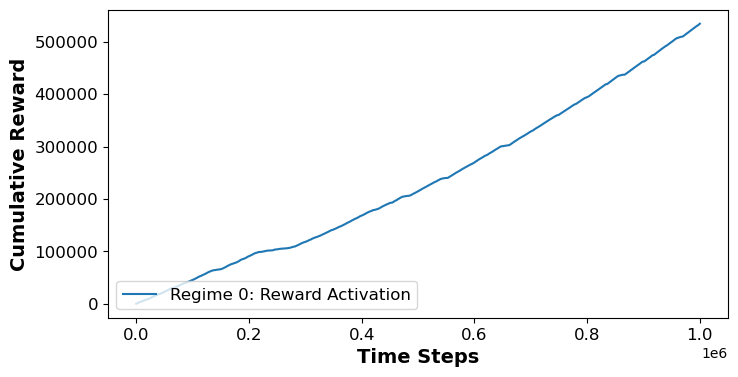

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
regime_names = ['Regime 0: Reward Activation', 'Regime 1: Left Right', 'Regime 2: Up Down', 'Regime 3: Random']
for regime, reward_history in enumerate([hs]):
    rh = np.array(reward_history[0])
    crh = np.cumsum(rh, axis=0)
    plt.plot(crh, label=regime_names[regime])
plt.legend(fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(-1.5e6, 0.1e6)
plt.legend(loc="lower left", fontsize=12)
plt.show()